In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

from utils.plotting import overlaySegment, countParameters, flow2img
from utils.layers import warp
from utils.encoding import dice_coeff, labelMatrixOneHot

In [2]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()

In [3]:
img = torch.load('Tests/img.pth') 
seg = torch.load('Tests/seg.pth')

fix = 9; mov = 10;
fixed = img[fix:fix+1,:,:].float() /255
moving = img[mov:mov+1,:,:].float() /255

fixed_seg = seg[fix:fix+1, :,:].long().contiguous()
moving_seg = seg[mov:mov+1,:,:].long().contiguous()

C,H,W = fixed.shape

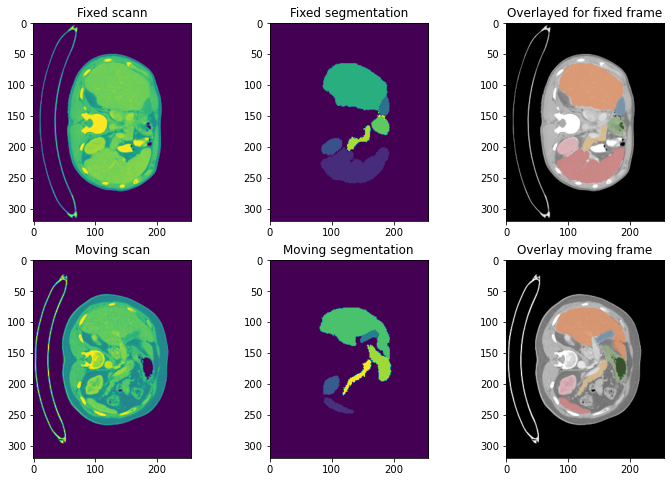

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title("Fixed scann")
plt.imshow(fixed.squeeze())
plt.subplot(232)
plt.title("Fixed segmentation")
plt.imshow(fixed_seg.squeeze())
plt.subplot(233)
plt.title("Overlayed for fixed frame")
plt.imshow(overlaySegment(fixed.squeeze(),fixed_seg.squeeze(), False).numpy())
plt.subplot(234)
plt.title("Moving scan")
plt.imshow(moving.squeeze())
plt.subplot(235)
plt.title("Moving segmentation")
plt.imshow(moving_seg.squeeze())
plt.subplot(236)
plt.title("Overlay moving frame")
plt.imshow(overlaySegment(moving.squeeze(),moving_seg.squeeze(),False).numpy())
plt.show()

### Check baseline Flow

In [5]:
in1 = fixed.view(H,W,1).numpy().astype(np.float32) / 255
in2 = moving.view(H,W,1).numpy().astype(np.float32) / 255

In [6]:
flow = baseline.calc(in1,in2,None)

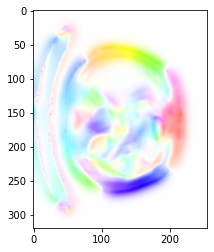

In [7]:
plt.imshow(flow2img(flow))

In [8]:
torch.from_numpy(flow).view(2,H,W).unsqueeze(0).shape

torch.Size([1, 2, 320, 256])

In [9]:
moving_seg.unsqueeze(0).shape

torch.Size([1, 1, 320, 256])

In [10]:
warped_seg = warp(moving_seg.float().unsqueeze(0).cuda(), torch.from_numpy(flow).view(2,H,W).unsqueeze(0).cuda()).cpu().to(torch.int64)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [11]:
warped_seg.shape

torch.Size([1, 1, 320, 256])

In [15]:
d0 = dice_coeff(moving_seg,fixed_seg,8)
print(d0, d0.mean())

tensor([0.2324, 0.8239, 0.0000, 0.0000, 0.7553, 0.6179, 0.6296]) tensor(0.4370)


In [16]:
d1 = dice_coeff(warped_seg.unsqueeze(0), fixed_seg,8)
print(d1, d1.mean())

tensor([0.2002, 0.7820, 0.0322, 0.0000, 0.7089, 0.5654, 0.5198]) tensor(0.4012)


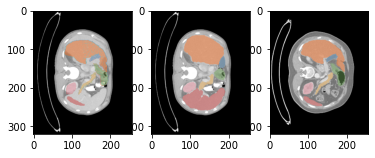

In [14]:
plt.subplot(131)
plt.imshow(overlaySegment(fixed.squeeze(),warped_seg.squeeze() ,False).numpy())
plt.subplot(132)
plt.imshow(overlaySegment(fixed.squeeze(),fixed_seg.squeeze() ,False).numpy())
plt.subplot(133)
plt.imshow(overlaySegment(moving.squeeze(),moving_seg.squeeze(),False).numpy())

### Verdict
- baseline already implemented
- sadly not finetunable.
- Maybe gridsearch for hyper params, on the validation dataset.
- good performance